In [43]:
import osmnx as ox
import sqlite3
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import psycopg2
import pickle
from itertools import combinations
from itertools import islice
from shapely import Point

ox.settings.log_file=True
ox.settings.log_console=True
ox.settings.use_cache=True

In [2]:
mm = ox.graph_from_place('Metro Manila')

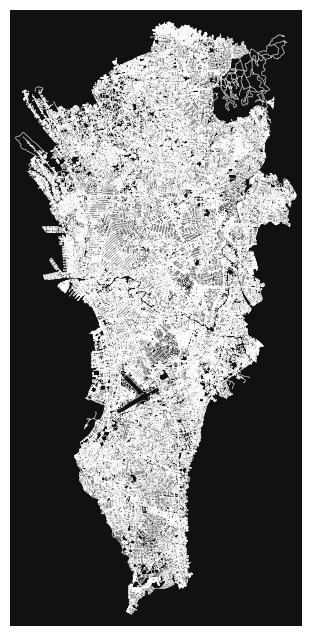

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
ox.plot_graph(mm, node_size=0.5, edge_linewidth=0.5)

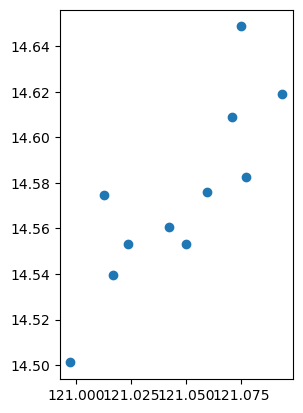

In [4]:
gogoro = pd.read_csv('Gogoro Stations.csv')
gogoro['Lat/Long'] = gogoro['Lat/Long'].str.split(', ')
gogoro['lat'] = gogoro['Lat/Long'].apply(lambda x: x[0])
gogoro['long'] = gogoro['Lat/Long'].apply(lambda x: x[1])
gogoro_gdf = gpd.GeoDataFrame(gogoro, geometry=gpd.points_from_xy(gogoro['long'], gogoro['lat']), crs='EPSG:4326')
gogoro_gdf.plot();

In [5]:
gogoro_nodes = {}
for i, row in gogoro_gdf.iterrows():
    gogoro_nodes[gogoro_gdf.iloc[i, 0]] = ox.distance.nearest_nodes(mm, row['geometry'].x, row['geometry'].y)

In [6]:
gogoro_stations = list(gogoro_nodes.keys())

In [9]:
distances = {}
for a, b in combinations(gogoro_stations, 2):
    route = nx.shortest_path_length(mm, gogoro_nodes[a], gogoro_nodes[b], weight='length')
    distances[(a,b)] = route

In [10]:
np.percentile(list(distances.values()), 10)

3280.9010000000003

In [11]:
malls = pd.read_csv('Ayala_Malls.csv')
malls['Lat/Long'] = malls['Lat/Long'].str.split(', ')
malls['lat'] = malls['Lat/Long'].apply(lambda x: x[0])
malls['long'] = malls['Lat/Long'].apply(lambda x: x[1])
malls_gdf = gpd.GeoDataFrame(malls, geometry=gpd.points_from_xy(malls['long'], malls['lat']), crs='EPSG:4326')
malls_nodes = {}
for i, row in malls_gdf.iterrows():
    malls_nodes[malls_gdf.iloc[i, 0]] = ox.distance.nearest_nodes(mm, row['geometry'].x, row['geometry'].y) 

In [12]:
conn = psycopg2.connect(dbname="postgis", 
                 user="gsa2022", 
                 password="g5!V%T1Vmd", 
                 host="192.168.212.99", 
                 port=32771)

In [13]:
mm_pts = gpd.read_postgis(
    '''
    SELECT p.*
    FROM ph_point p
    JOIN gadm.ph g ON st_within(p.way, g.geom)
    WHERE p.amenity != 'None'
    AND g.name_1 = 'Metropolitan Manila'
    ''',
    conn,
    geom_col='way'
)

/opt/conda/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [56]:
gas_pts = gpd.read_postgis(
    '''
    SELECT p.*
    FROM ph_point p
    JOIN gadm.ph g ON st_within(p.way, g.geom)
    WHERE p.amenity != 'None'
    AND g.name_1 = 'Metropolitan Manila'
    AND p.amenity = 'fuel'
    AND (lower(p.name) like '%sea%' OR lower(p.name) like '%phoenix%')
    ''',
    conn,
    geom_col='way'
)

/opt/conda/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [58]:
gas_nodes = {}
for i, row in gas_pts.iterrows():
    gas_nodes[i] = ox.distance.nearest_nodes(mm, row['way'].x, row['way'].y) 

In [57]:
grocery_pts = gpd.read_postgis(
    '''
    SELECT p.*
    FROM ph_point p
    JOIN gadm.ph g ON st_within(p.way, g.geom)
    WHERE 1=1
    AND g.name_1 = 'Metropolitan Manila'
    AND p.shop in ('supermarket', 'grocery')
    AND lower(p.name) like '%puregold%'
    AND lower(p.name) not like '%jr%'
    ''',
    conn,
    geom_col='way'
)

/opt/conda/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [59]:
grocery_nodes = {}
for i, row in grocery_pts.iterrows():
    grocery_nodes[i] = ox.distance.nearest_nodes(mm, row['way'].x, row['way'].y) 

In [18]:
mm_shp = gpd.read_postgis(
    '''
    SELECT *
    FROM gadm.ph_brgy
    WHERE 1=1
    AND name_1 = 'Metropolitan Manila'
    ''',
    conn,
    geom_col='geom'
)

/opt/conda/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [23]:
brgy_nodes = {}
for i, row in mm_shp.iterrows():
    brgy_nodes[i] = ox.distance.nearest_nodes(mm, row['geom'].centroid.x, row['geom'].centroid.y) 

In [24]:
brgy_nodes_list = list(brgy_nodes.values())

In [25]:
with open('brgy.pkl', 'wb') as f:
    pickle.dump(brgy_nodes, f)

In [26]:
with open('brgy.pkl', 'rb') as f:
    pickle.load(f)
    brgy_nodes = f

In [27]:
iso_colors = ox.plot.get_colors(n=len(gogoro_nodes), cmap='viridis', start=0, return_hex=True)

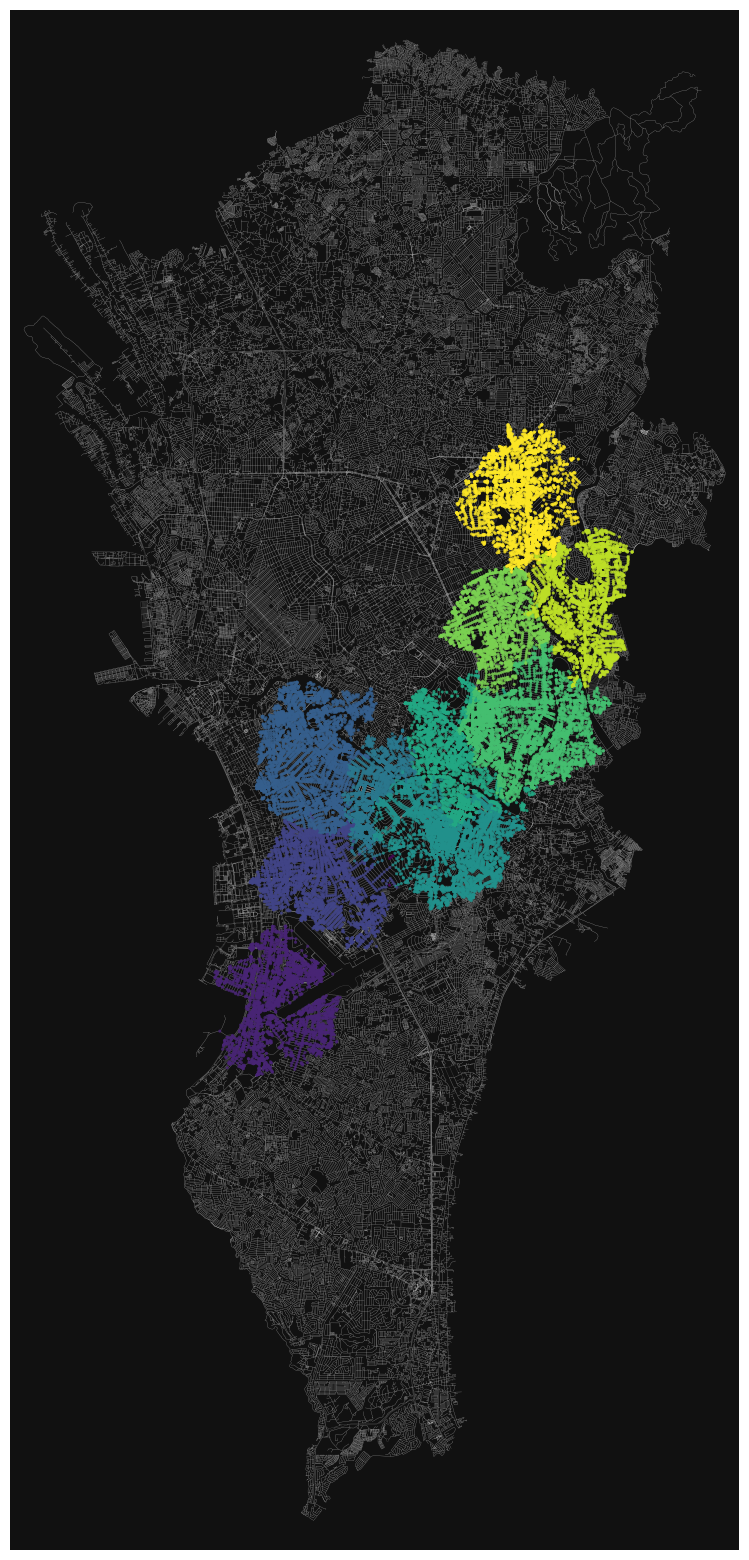

In [28]:
node_colors = {}
for station, color in zip(gogoro_nodes.values(), iso_colors):
    dist = nx.single_source_dijkstra_path_length(mm, station, cutoff=3000, weight='length')
    # subgraph = nx.ego_graph(mm, station, radius=85, distance='weight')
    for node in dist:
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in mm.nodes()]
ns = [5 if node in node_colors else 0 for node in mm.nodes()]
fig, ax = ox.plot_graph(mm, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='white', edge_alpha=0.3, figsize=(15, 20))

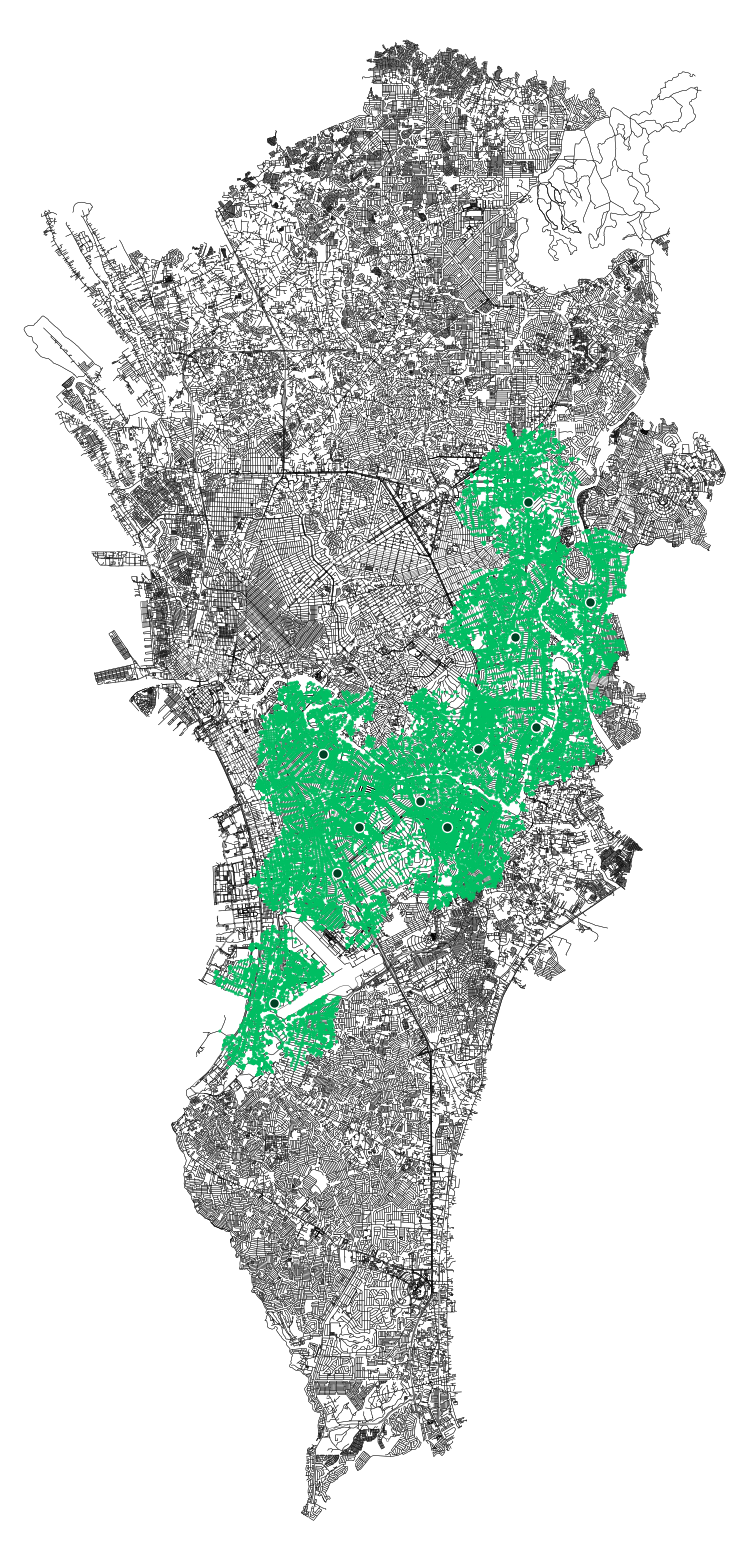

In [29]:
node_colors = {}
for station in gogoro_nodes.values():
    dist = nx.single_source_dijkstra_path_length(mm, station, cutoff=3000, weight='length')
    # subgraph = nx.ego_graph(mm, station, radius=85, distance='weight')
    for node in dist:
        node_colors[node] = 1
nc = ['#00bf63' if node in node_colors else 'none' for node in mm.nodes()]
ns = [5 if node in node_colors else 0 for node in mm.nodes()]
fig, ax = ox.plot_graph(mm, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.3, edge_color='black', edge_alpha=0.8,
                        figsize=(15, 20), show=False, close=False,
                       bgcolor='white')
gogoro_gdf.plot(ax=ax, color='#004225', markersize=50, edgecolor='white')
plt.savefig('gogoro_network.png', dpi=300)
plt.show()

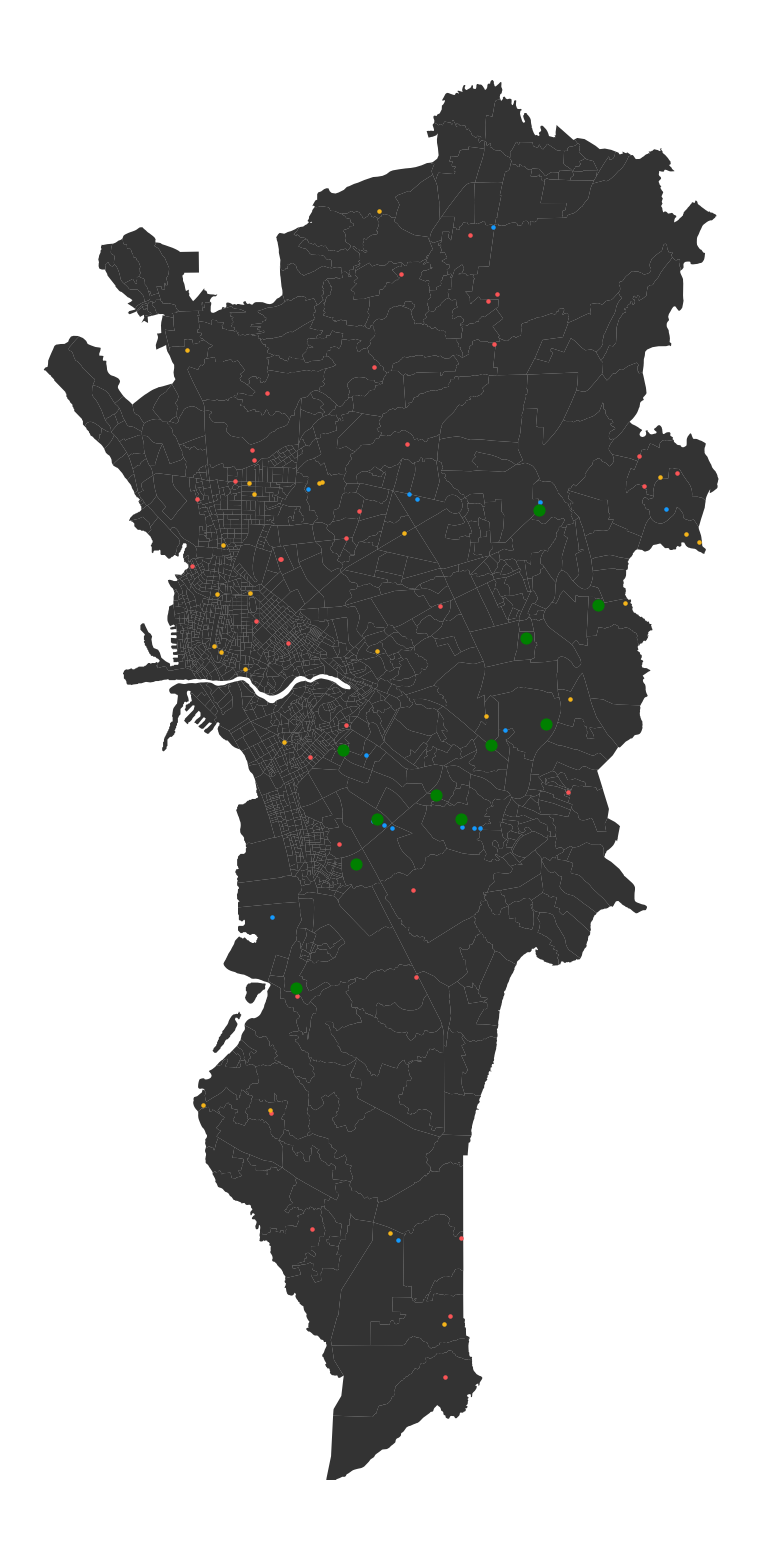

In [30]:
# Plotting our two objects together
ax = mm_shp.plot(figsize=(15,20), color='black', alpha=0.8)
gas.plot(ax=ax, color='#FA5456', markersize=5)
grocery.plot(ax=ax, color='#f4b41a', markersize=5)
malls_gdf.plot(ax=ax, color='#149aff', markersize=5)
gogoro_gdf.plot(ax=ax, color='green', markersize=60)
ax.set_axis_off()

In [31]:
gogoro_capture = {}
for station in gogoro_nodes.values():
    dist = nx.single_source_dijkstra_path_length(mm, station, cutoff=3000, weight='length')
    captured_brgy = [node for node in dist.keys() if node in brgy_nodes_list]
    gogoro_capture[station] = captured_brgy

In [32]:
capture_dict = {}
for gas in gas_nodes.values():
    dist = nx.single_source_dijkstra_path_length(mm, gas, cutoff=3000, weight='length')
    captured_brgy = [node for node in dist.keys() if node in brgy_nodes_list]
    capture_dict[gas] = captured_brgy

In [33]:
for grocery in grocery_nodes.values():
    dist = nx.single_source_dijkstra_path_length(mm, grocery, cutoff=3000, weight='length')
    captured_brgy = [node for node in dist.keys() if node in brgy_nodes_list]
    capture_dict[grocery] = captured_brgy

In [34]:
for mall in malls_nodes.values():
    dist = nx.single_source_dijkstra_path_length(mm, mall, cutoff=3000, weight='length')
    captured_brgy = [node for node in dist.keys() if node in brgy_nodes_list]
    capture_dict[mall] = captured_brgy

In [35]:
def compute_brgy_captured(capture_dict):
    brgy_counter = pd.Series({node: len(brgy) for node, brgy in capture_dict.items()})
    return brgy_counter.idxmax(), brgy_counter.max()

In [36]:
gogoro_brgys = set()
for v in gogoro_capture.values():
    gogoro_brgys.update(set(v))

In [37]:
def remove_intersect(nodes_list, captured_dict):
    new_dict = {}
    for node in nodes_list:
        for station, brgy_list in captured_dict.items():
            if node in brgy_list:
                brgy_list.remove(node)
            if len(brgy_list):
                new_dict[station] = brgy_list
    return captured_dict

In [38]:
cap_dict = remove_intersect(list(gogoro_brgys), capture_dict)

In [39]:
captured_brgy_per_station = [len(gogoro_brgys)]
final_brgy_dict = {}
n = len(cap_dict)
i = 1
while i < n:
    max_node, brgy_count = compute_brgy_captured(cap_dict)
    captured_brgy_per_station.append(brgy_count)
    brgy_nodes = cap_dict.pop(max_node)
    final_brgy_dict[max_node] = brgy_nodes
    cap_dict = remove_intersect(brgy_nodes, cap_dict)
    i += 1

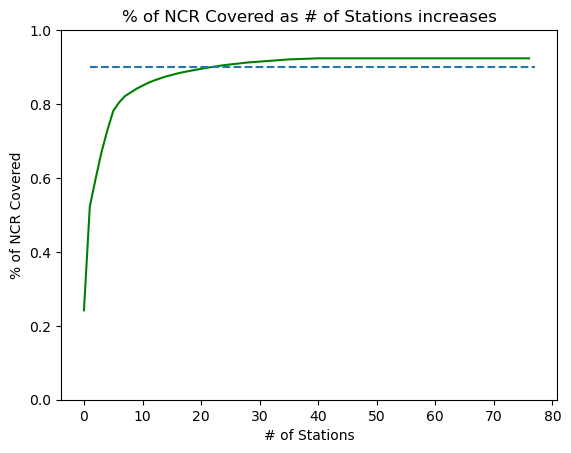

In [40]:
plt.plot(
    range(0, n),
    np.array(captured_brgy_per_station).cumsum()/len(mm_shp),
    'g'
)
plt.hlines(0.9, 1, n, linestyles='--')
plt.xlabel('# of Stations')
plt.ylabel('% of NCR Covered')
plt.ylim(0, 1)
plt.title('% of NCR Covered as # of Stations increases')

plt.savefig('graph.png', dpi=300)
plt.show()

In [41]:
np.sum(captured_brgy_per_station[:23])

1523

In [44]:
gogoro_brgy_coord = []
for node in gogoro_brgys:
    y = mm.nodes[node]['y']
    x = mm.nodes[node]['x']
    gogoro_brgy_coord.append(Point(x, y))

In [45]:
query = "SELECT * FROM gadm.ph_brgy WHERE "
conditions = []

for point in gogoro_brgy_coord:
    conditions.append(f"ST_Contains(geom, ST_GeomFromText('{point}', 4326))")

query += " OR ".join(conditions) + ";"

In [46]:
gogoro_brgy_df = gpd.read_postgis(
    query,
    conn,
    geom_col='geom'
)

/opt/conda/lib/python3.10/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [47]:
gogoro_brgy_df['tag'] = 'gogoro'

In [48]:
first_20_stations = dict(islice(final_brgy_dict.items(), 22))

In [49]:
final = {}
for station, brgy_nodes in first_20_stations.items():
    this_list = []
    for node in brgy_nodes:
        y = mm.nodes[node]['y']
        x = mm.nodes[node]['x']
        this_list.append((x, y))
    final[station] = this_list

In [50]:
station_number = {}
for i, key in enumerate(final.keys()):
    station_number[key] = i+1

In [51]:
mm_shp['tag'] = None

for key, points_list in final.items():
    # Convert list of points to GeoSeries
    points_geoseries = gpd.GeoSeries([Point(x, y) for x, y in points_list])
    
    # Loop through each point and tag barangays that contain the point
    for point in points_geoseries:
        # Identify barangays containing the point
        contains_point = mm_shp.contains(point)
        
        # Tag these barangays with the current key
        mm_shp.loc[contains_point, 'tag'] = station_number[key]

In [52]:
station_coords = [
    (mm.nodes[node]['x'], mm.nodes[node]['y'])
    for node in final.keys()
]

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:819: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(values, categories=categories)


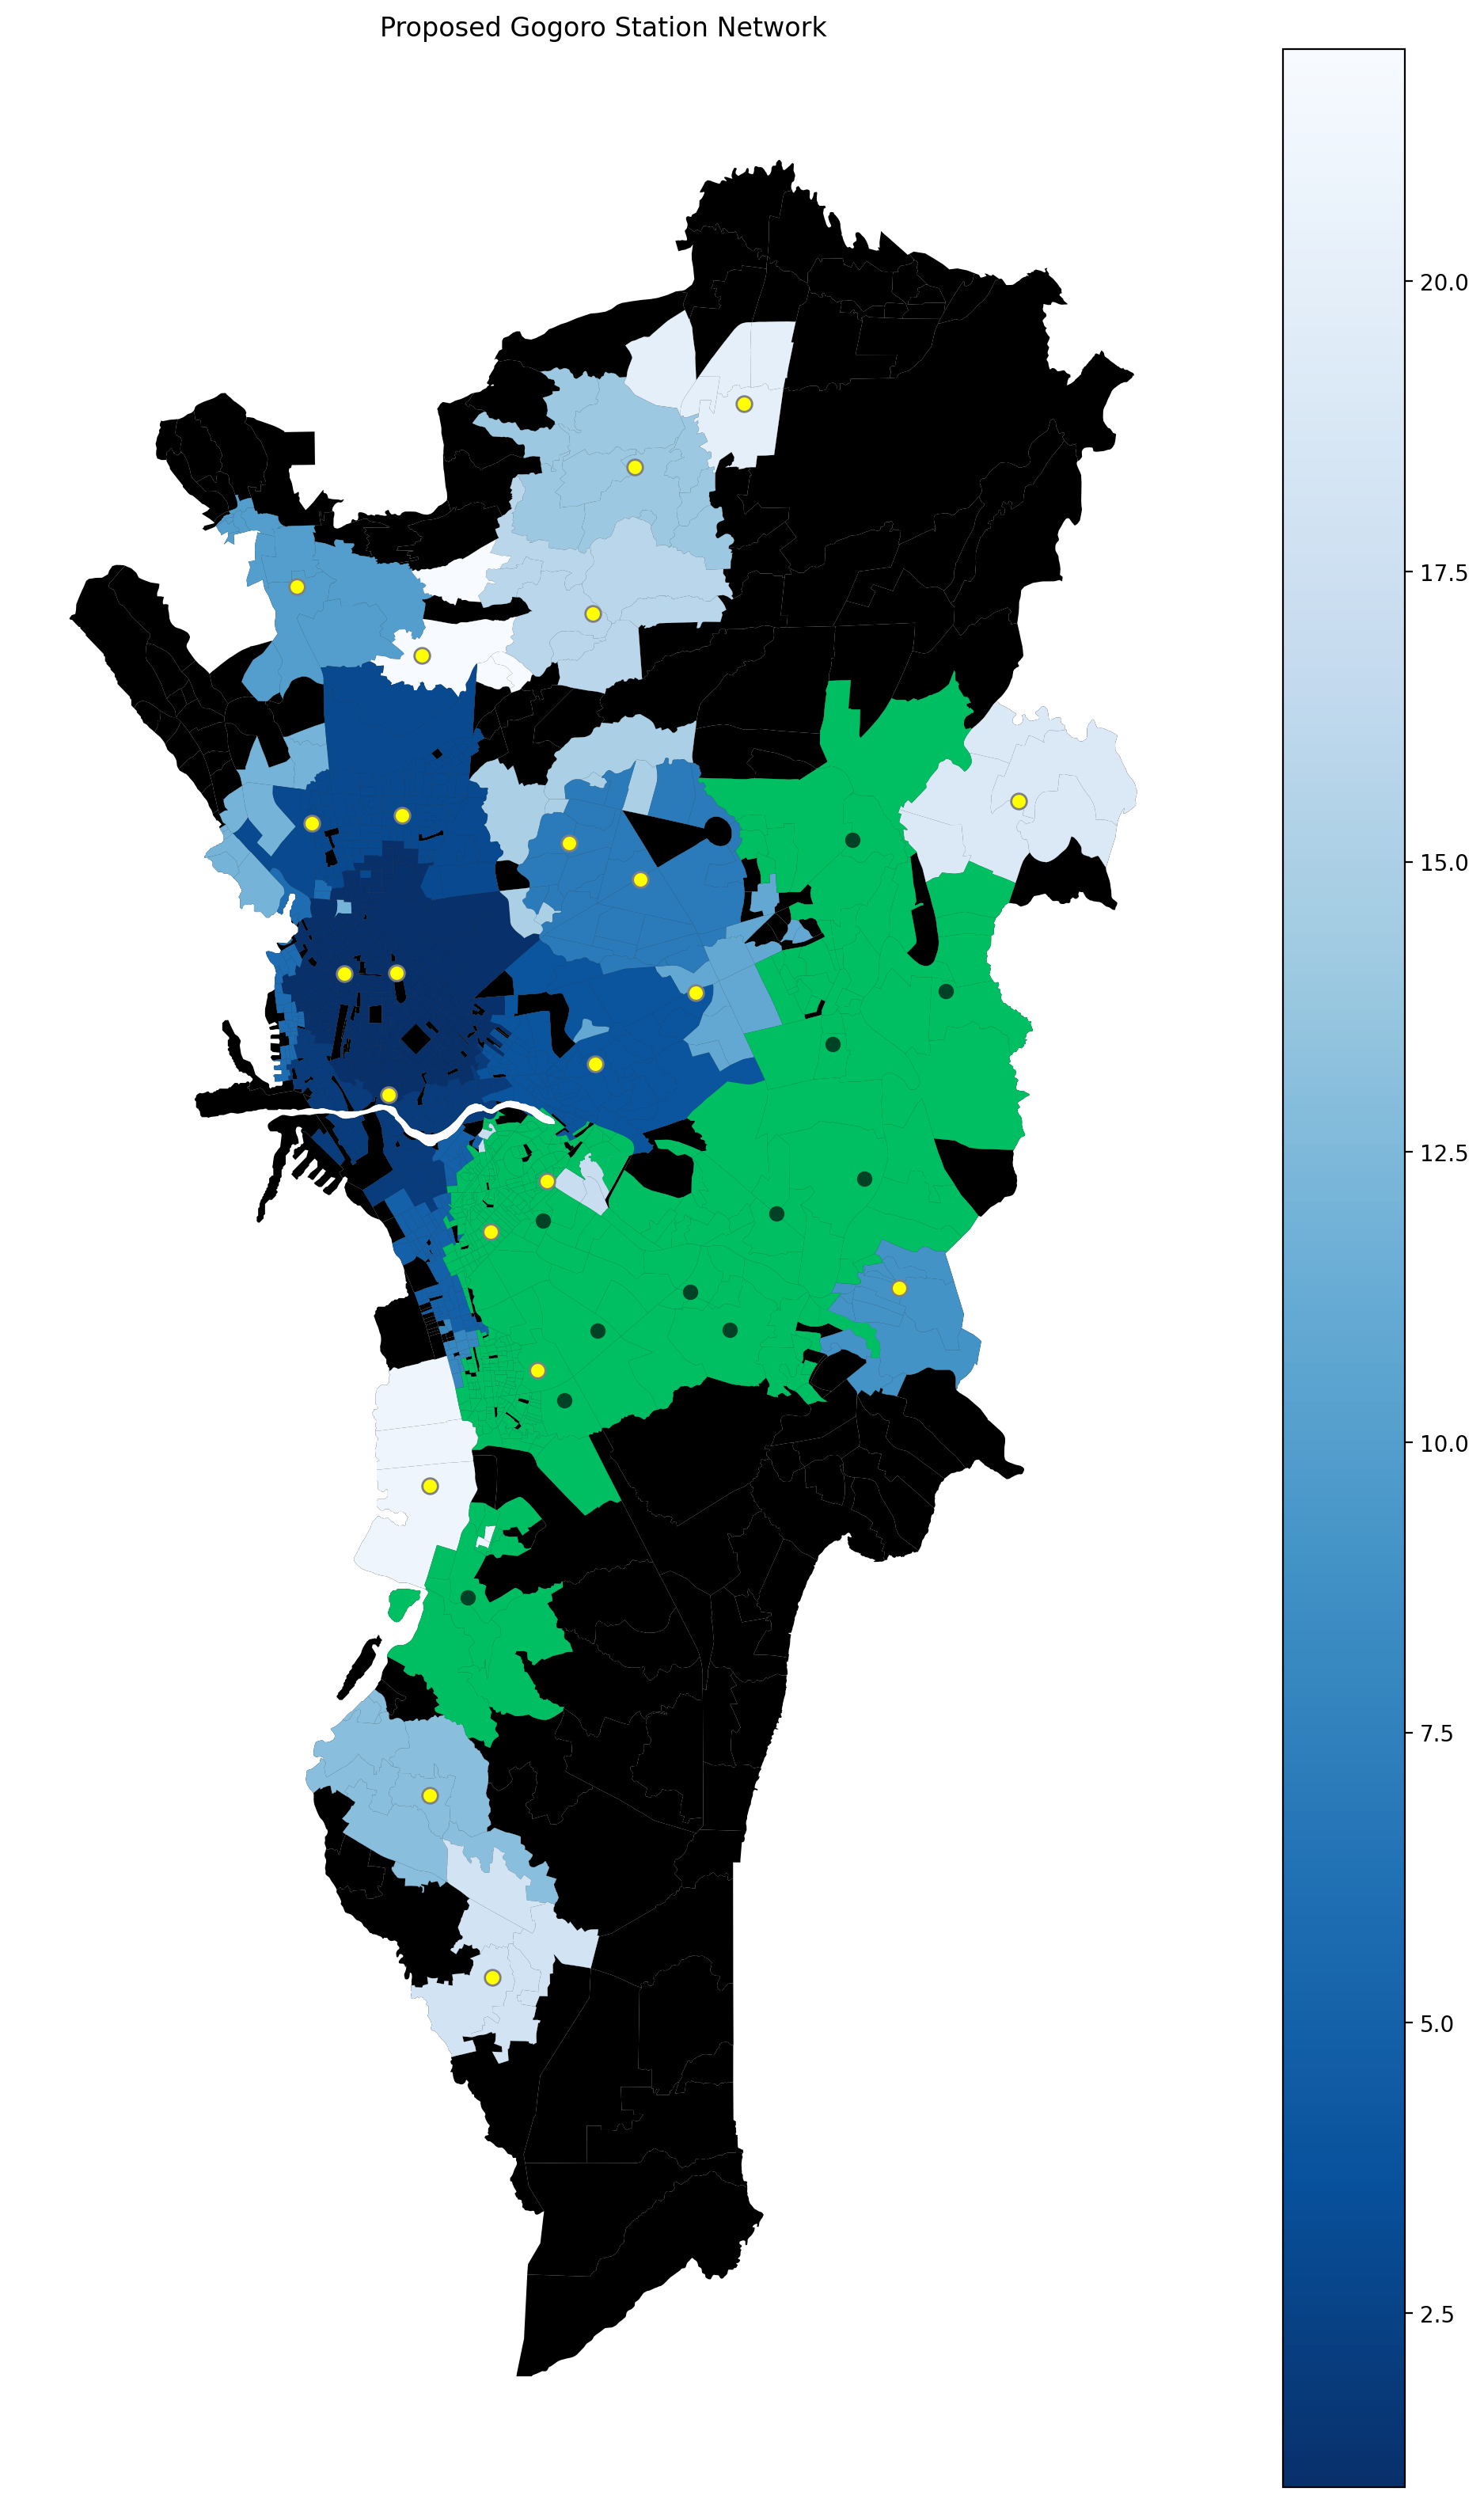

In [53]:
fig, ax = plt.subplots(figsize=(15, 20), dpi=200)
mm_shp.plot(facecolor='black', ax=ax)
mm_shp.plot(column='tag', cmap='Blues_r', ax=ax)

sm = plt.cm.ScalarMappable(cmap='Blues_r', norm=plt.Normalize(vmin=mm_shp['tag'].min(), vmax=mm_shp['tag'].max()))
sm._A = []
fig.colorbar(sm, ax=ax)
gogoro_brgy_df.plot(facecolor='#00bf63', ax=ax)

for x, y in station_coords:
    plt.scatter(x, y, 50, 'yellow', edgecolor='gray')
gogoro_gdf.plot(facecolor='#004225', ax=ax)
ax.set_axis_off()
plt.title('Proposed Gogoro Station Network')
fig.savefig('colored_mm_stations.png', dpi=300)

plt.show()

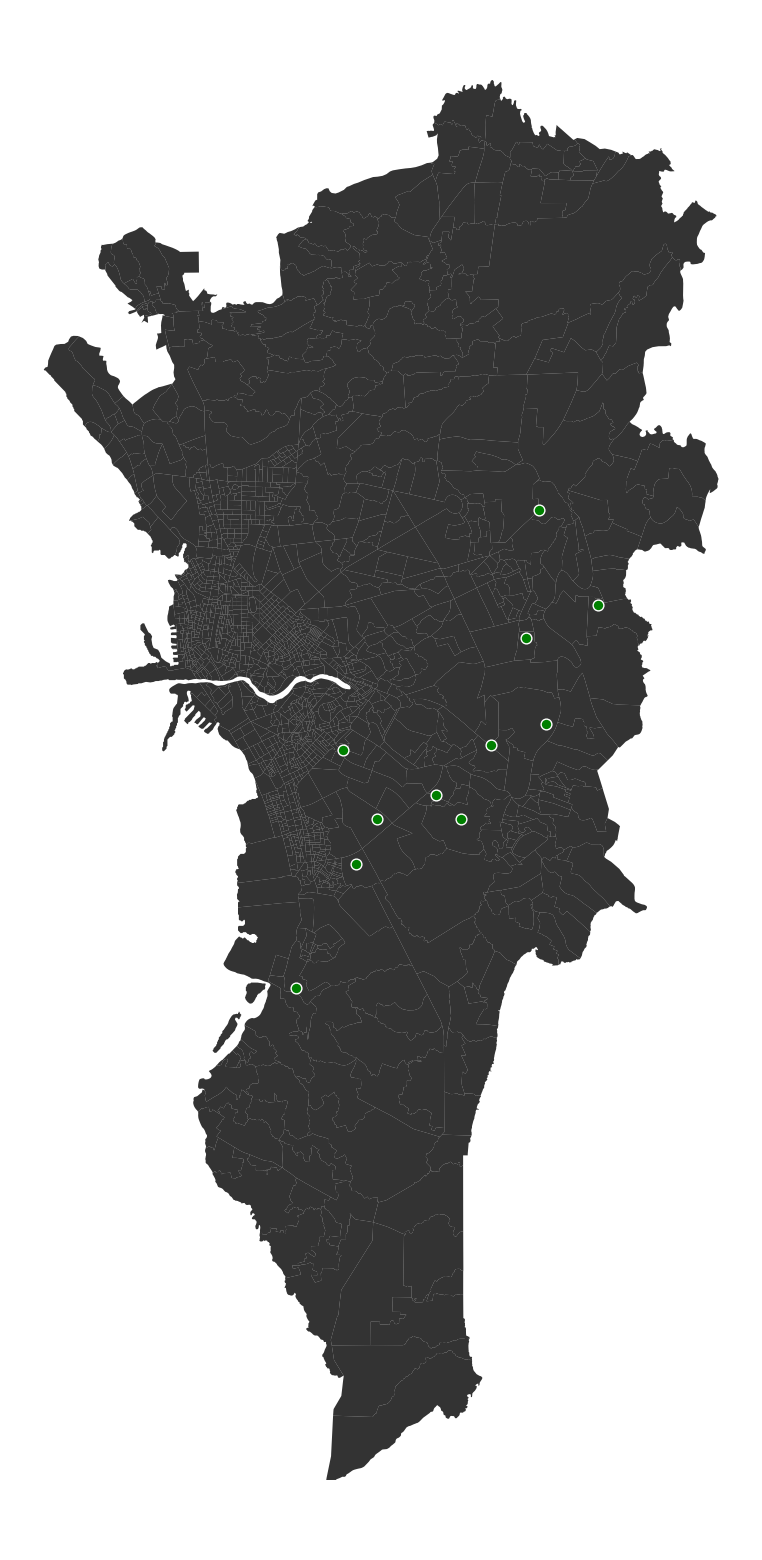

In [54]:
# Plotting our two objects together
ax = mm_shp.plot(figsize=(15,20), color='black', alpha=0.8)
gogoro_gdf.plot(ax=ax, facecolor='green', edgecolor='white', markersize=60)
ax.set_axis_off()
plt.savefig('gogoro_stations.png', dpi=300)

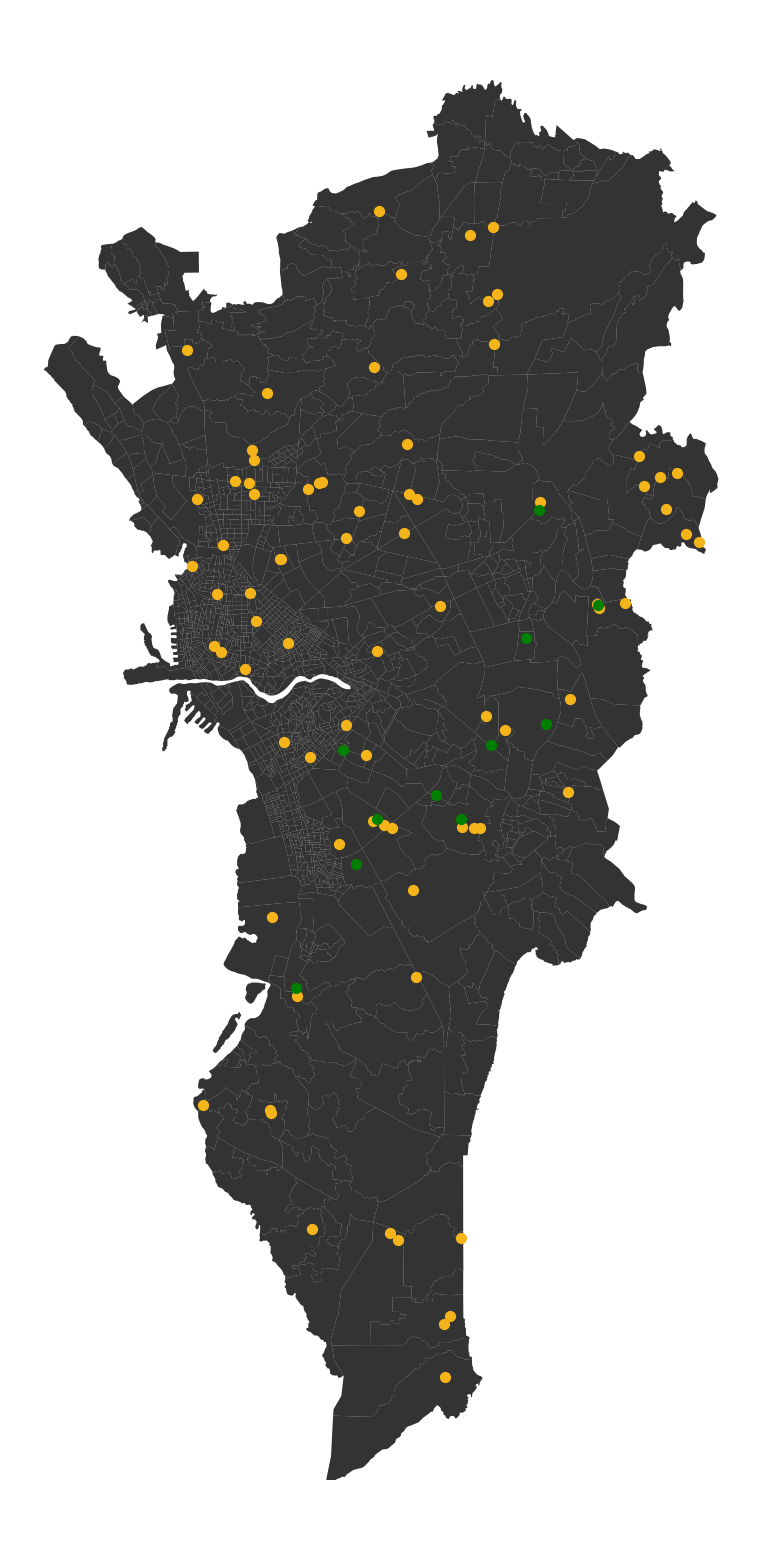

In [60]:
# Plotting our two objects together
ax = mm_shp.plot(figsize=(15,20), color='black', alpha=0.8)
gas_pts.plot(ax=ax, color='#f4b41a', markersize=50)
grocery_pts.plot(ax=ax, color='#f4b41a', markersize=50)
malls_gdf.plot(ax=ax, color='#f4b41a', markersize=50)
gogoro_gdf.plot(ax=ax, color='green', markersize=50)
ax.set_axis_off()
plt.savefig('gogoro_and_possible.png', dpi=300)

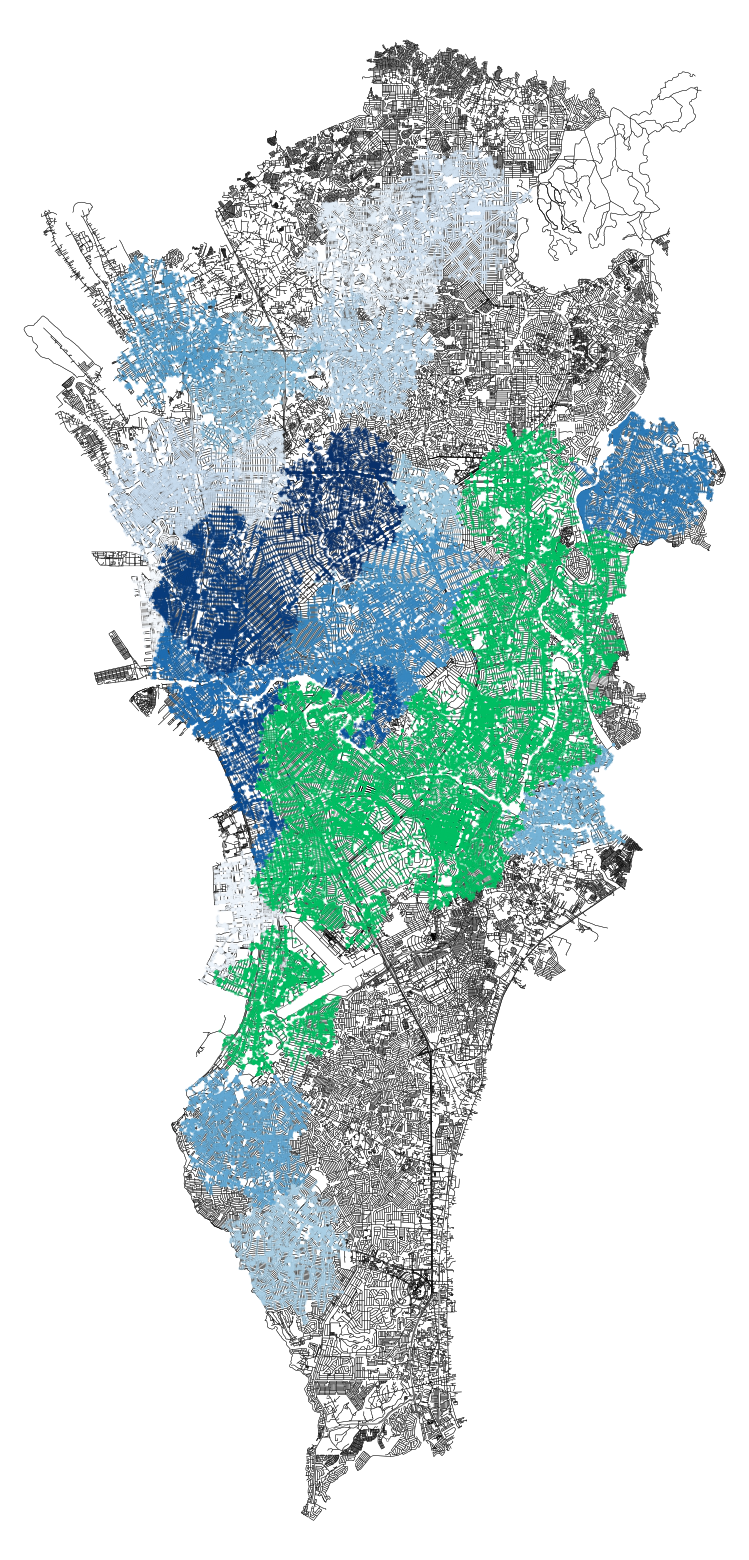

In [61]:
iso_colors = ox.plot.get_colors(n=len(final), cmap='Blues', start=0, return_hex=True)
gogoro_colors = {}
node_colors = {}
for station, color in zip(sorted(final.keys(), reverse=True), iso_colors):
    dist = nx.single_source_dijkstra_path_length(mm, station, cutoff=3000, weight='length')
    for node in dist:
        node_colors[node] = color
for station in gogoro_nodes.values():
    dist = nx.single_source_dijkstra_path_length(mm, station, cutoff=3000, weight='length')
    for node in dist:
        gogoro_colors[node] = '#00bf63'

nc1 = [node_colors[node] if node in node_colors else 'none' for node in mm.nodes()]
ns1 = [5 if node in node_colors else 0 for node in mm.nodes()]
for i, node in enumerate(mm.nodes()):
    if node in gogoro_colors:
        nc1[i] = gogoro_colors[node]
        ns1[i] = 5
fig, ax = ox.plot_graph(mm, node_color=nc1, node_size=ns1, node_alpha=0.5,
                        edge_linewidth=0.3, edge_color='black', edge_alpha=0.8,
                        figsize=(15, 20), bgcolor='white')

fig.savefig('network_isodistance_white.png', dpi=300)